# DQN Extensions

* The Mathematics behind the overestimatied Q-values
* Double DQN
* Dueling DQN


## DQN basics

In this class we use more generic $\theta$ to represent the parameters for the model of Q function.

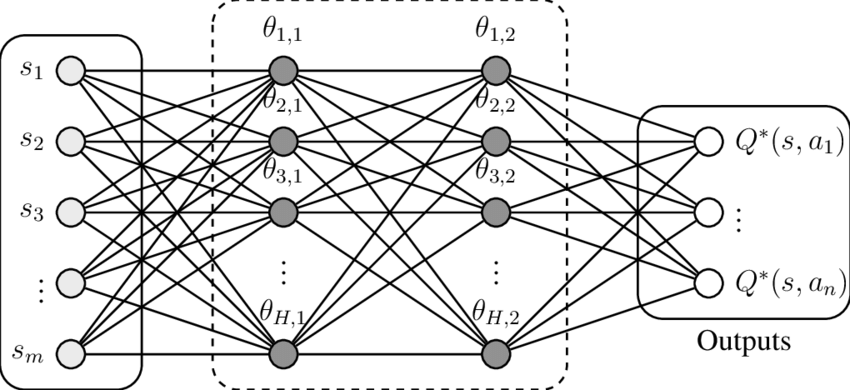

## Target network to make training stable

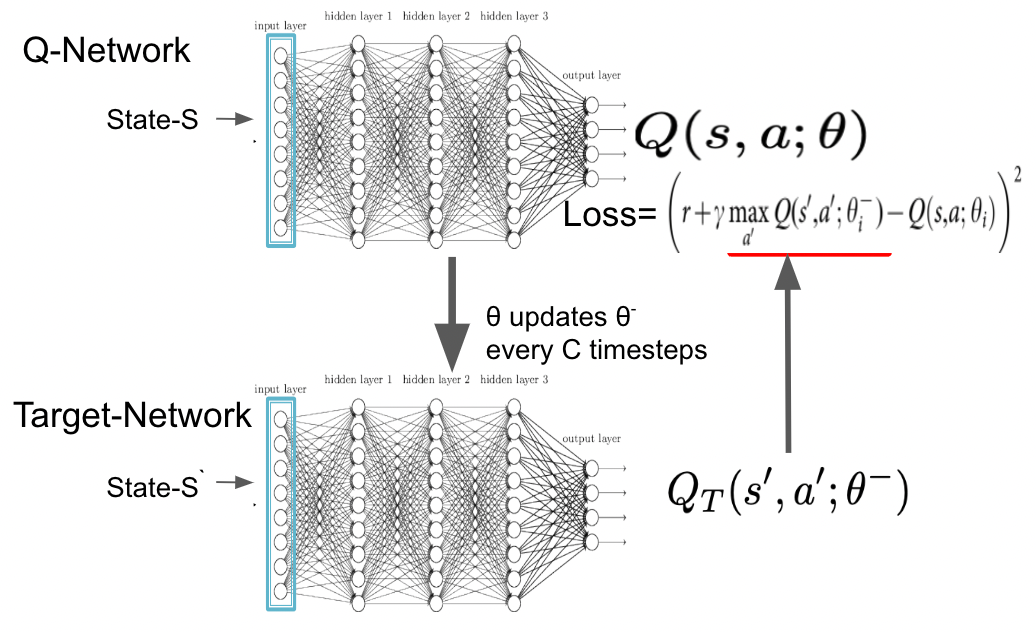

## The loss function

$$\large \mathcal{\theta}^* = \arg\min_{\mathcal{\theta}} \frac{1}{2N}\sum_{i=1}^{N}\left[ Q_\mathcal{\theta}\left(s_{i}, a_{i}\right) - [r_i+ \gamma  \max_{a'} Q_\mathcal{\theta^-}\left(s'_{i}, a'_{i}\right)] \right]^2$$

## Rethink about overestimation of Q-values

* DQN has been observed to estimate unrealistically high 𝑄-values. 
* The reason for this is, that the Bellman equation includes a maximization step over estimated action values, which tends to prefer overestimated to underestimated values.

Some basic analysis:

* The estimated $Q$-values are noisy. 
* Assume that the true $Q$-value is 0 for all actions. But because of the noisy estimation, some $Q$-values might be slightly positive, others slightly negative. 
* The max operation in the Bellman equation will however always chose the small positive values, despite the fact, that those actions are not truly better. 
* The estimation of $Q$-values is thus biased towards larger values. 

Mathematically, the reason for the overestimation is, that **<font color=red>the expectation of a maximum is greater than or equal to the maximum of an expectation</font>**


## Mathematical analysis of overestimated Q-value

Let's simplify the problem a little bit.

* Assume that in the state $s$, all the Q-values for every action are same, i.e., $Q^*(s, a)=V^*(s)$
* However, our deep net model has a uniform random error. 
    - the random error is defined as $Q_{\theta^-}(s, a)-V^*(s)$, where $\theta^-$ is the target network
    - To keep it simple, assume the error is in a uniform distribution between $-1$ and $1$. 
    - assume the action space is $m$
    
* Here we want to show,

$$\large \mathbb{E} \left[ \max_a Q_{\theta^-}(s, a) -  \max_{a'} Q^*(s, a') \right] = \frac {m-1}{m+1} $$

The error is defined as

$$\large \epsilon_a = Q_{\theta^-}(s, a) -  \max_{a'} Q^*(s, a') $$

Assume there is an upper bound $x$ for all $\epsilon_a$, so the probatility is 

$$\large \mathrm{P}( \text{all of } \epsilon_a \le x) = \mathrm{P}( \max_a \epsilon_a \le x)  $$

Since the estimation for each action is independent, then we have

$$\large \mathrm{P}( \max_a \epsilon_a \le x) = \prod_{a=1}^{m}\mathrm{P}(\epsilon_a \le x) $$

Since $\mathrm{P}(\epsilon_a \le x)$ is cumulative distribution function (CDF) of a uniform distribution between $-1$ and $1$, we have

$$\large
\begin{equation}
  \mathrm{P}(\epsilon_a \le x) = 
    \begin{cases}
      0 & \text{if $x \le -1$}\\
      \frac{1+x}{2} & \text{if $x\in (-1, 1)$}\\
      1 & \text{if $x \ge -1$}
    \end{cases}       
\end{equation}
$$

https://www.alphacodingskills.com/scipy/scipy-uniform-distribution.php

Then we get

$$\large \begin{aligned}
\mathrm{P}( \max_a \epsilon_a \le x) &= \prod_{a=1}^{m}\mathrm{P}(\epsilon_a \le x) \\
&=\begin{cases}
      0 & \text{if $x \le -1$}\\
      (\frac{1+x}{2})^m & \text{if $x\in (-1, 1)$}\\
      1 & \text{if $x \ge -1$}
    \end{cases}       
\end{aligned}$$

Finally we get

$$\large \begin{aligned}
\mathbb{E} \left[ \max_a \epsilon_a \right]  &=\int_{-1}^{1} x\frac{d  }{dx} \mathrm{P}( \max_a \epsilon_a \le x)dx \\
&= \left[ \left( \frac{x+1}{2} \right)^m \frac{mx-1}{m+1}\right]\Biggr|_{-1}^{1} \\
&= \frac{m-1}{m+1}
\end{aligned} $$

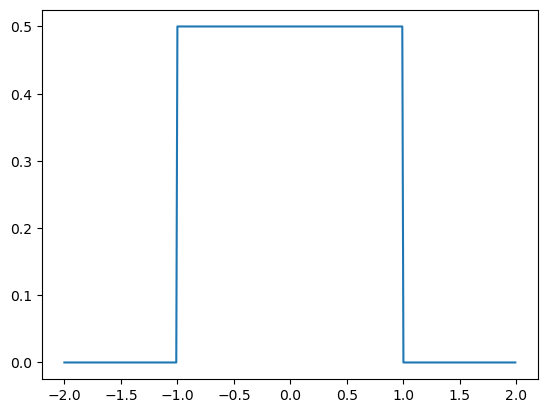

In [1]:
from scipy.stats import uniform
import matplotlib.pyplot as plt
import numpy as np

#creating an array of values between
#-1 to 1 with a difference of 0.01
x = np.arange(-2, 2, 0.01)
   
y = uniform.pdf(x, -1, 2)
   
plt.plot(x, y) 
plt.show()

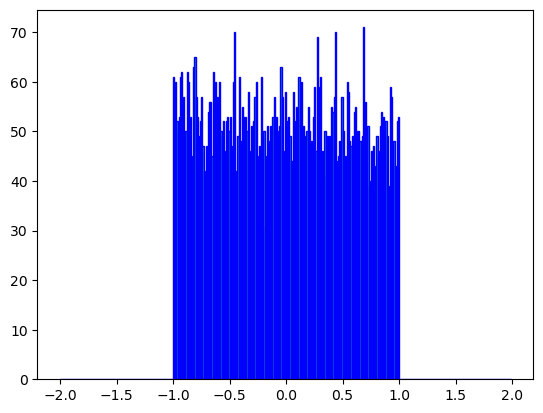

In [2]:
#fixing the seed for reproducibility
#of the result
np.random.seed(10)

#creating a vector containing 10000
#uniformly distributed random numbers
y = uniform.rvs(-1, 2, 10000)

#creating bin
bin = np.arange(-2,2,0.01)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

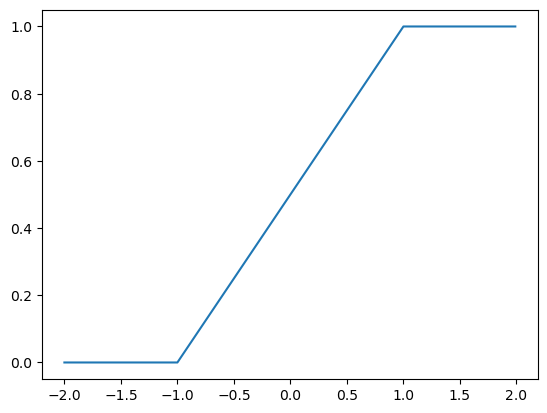

In [3]:
#creating an array of values between
#-1 to 1 with a difference of 0.01
x = np.arange(-2, 2, 0.01)
   
y = uniform.cdf(x, -1, 2)
   
plt.plot(x, y) 
plt.show()

## Let's see how the action space impacts the probability density

input function as ((x+1)/2)^m 

https://www.derivative-calculator.net/

## Double DQN

* Instead of estimating the $Q$-values in the next state $Q(s',a')$ with only the target network, we use the main network to estimate which action is the best and then ask the target network how high the $Q$-value is for that action. 
* This way, the main network will still prefer the action with the small positive $Q$-value but because of the noisy estimation, the target network will predict a small positive **or** small negative $Q$-value for that action and on average, the predicted $Q$-values will be closer to 0.

The Bellman equation changes from

$$\large
\begin{align}
Q_\text{target}(s,a) &= r + \gamma \textrm{max} Q(s',a';\theta_\text{target}) &\text{Vanilla DQN}\\
\text{which is equivalent to}\qquad\qquad Q_\text{target}(s,a) &= r + \gamma Q\left(s',a'=\text{argmax} Q(s',a';\theta_\text{target});\theta_\text{target}\right) &\text{still the Vanilla DQN}\\
\text{change to}\qquad\qquad Q_\text{target}(s,a) &= r + \gamma Q\left(s',a'=\text{argmax} Q(s',a';\theta_\text{main});\theta_\text{target}\right)&\text{Double DQN}
\end{align}$$

* The main network estimates which action $a'$ (in the next state $s'$) is best (that is the $\text{argmax} Q(s',a';\theta_\text{main})$ part). 
* The target network then estimates what the $Q$-value for that action is. 
* This $Q$-value has to be discounted with $\gamma$ and is then added to the reward $r$ the agent got for action $a$ (not $a'$).

Notes:

* Vanilla DQN: 
    - Ask the target network for the highest $Q$-Value. 
    - If the noisy $Q$-values are for example $(0.1,-0.1)$ for actions with index $0$ and $1$ respectively, the target $Q$-network will answer $0.1$.

* Double DQN: 
    - Ask the main network which action has the highest $Q$-value. 
    - If the noisy $Q$-values are for example $(0.1,-0.1)$ for actions with index $0$ and $1$ respectively, the main network will answer that action with index $0$ has the highest $Q$-value. 
    - Then we ask the target network, **which has a different noise**, what the $Q$-value for the action with the chosen index ($0$ in this example) is. 
    - Let's assume the target network's noisy estimates are $(-0.05,0.3)$ it will answer $-0.05$.  

* This solves the problem of overestimated $Q$-values because **the two networks have different noise and the bias towards slightly larger noisy $Q$-values cancels.**


* If the game is over (`terminal=True`) because the agend lost or won, there is no next state and the $Q_\text{target}$-value is simply the reward $r$.

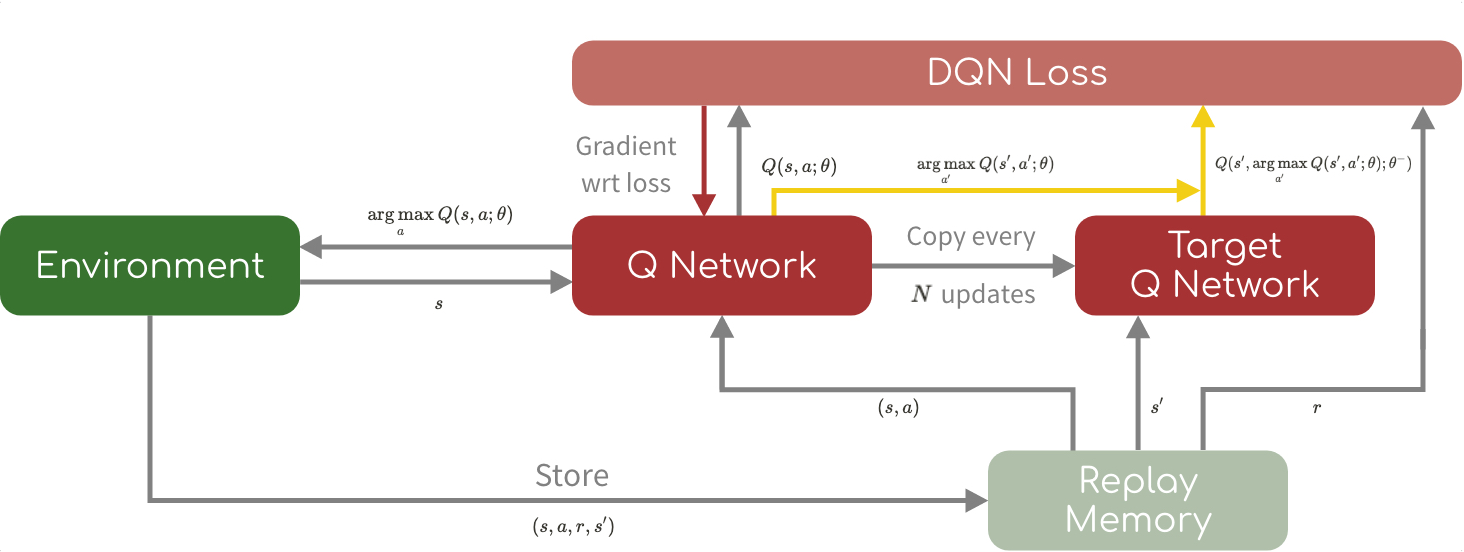

## Inverted Pendulum

<img src="https://upload.wikimedia.org/wikipedia/commons/9/93/Cart-pole_swing_up.gif" width="750" align="center">

* A different version of Cart-pole
* We will skip the physical dynamics in this class. https://en.wikipedia.org/wiki/Inverted_pendulum
* Continuous action space
* The purpose is to stabilize the pendulum in its unstable equilibrium position θ = π by controlling the motion of the cart only, which is itself driven by a target velocity provided by a controller.

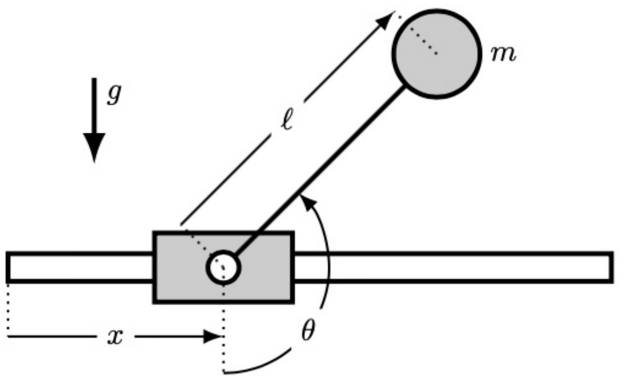

### Action Space

The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.

| Num | Action | Min  | Max |
|-----|--------|------|-----|
| 0   | Torque | -2.0 | 2.0 |


### Observation Space

The observation is a `ndarray` with shape `(3,)` representing the x-y coordinates of the pendulum's free
end and its angular velocity.

| Num | Observation      | Min  | Max |
|-----|------------------|------|-----|
| 0   | x = cos(theta)   | -1.0 | 1.0 |
| 1   | y = sin(theta)   | -1.0 | 1.0 |
| 2   | Angular Velocity | -8.0 | 8.0 |

### Rewards (Nice to know)

The reward function is defined as:

*r = -(theta<sup>2</sup> + 0.1 * theta_dt<sup>2</sup> + 0.001 * torque<sup>2</sup>)*

where $\theta$ is the pendulum's angle normalized between *[-pi, pi]* (with 0 being in the upright position).

Based on the above equation, the minimum reward that can be obtained is

*-(pi<sup>2</sup> + 0.1 * 8<sup>2</sup> + 0.001 * 2<sup>2</sup>) = -16.2736044*,

while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

### Starting State

The starting state is a random angle in *[-pi, pi]* and a random angular velocity in *[-1,1]*.

## Some interesting videos

* Inverted single pendulum

https://www.youtube.com/watch?v=lM6rYjM6HBU

* Inverted double pendulum. It is super cool, though we don't cover in this class.

https://www.youtube.com/watch?v=IfQx0ttI5vM

https://www.youtube.com/watch?v=K3Crq_iuXv8

* Inverted triple pendulum

https://www.youtube.com/watch?v=SWupnDzynNU

* Inverted quadruple pendulum

https://www.youtube.com/watch?v=cp731cKgoHw

https://www.youtube.com/watch?v=IXLXmB6NCr4

* Inverted quintuple pendulum

https://www.youtube.com/watch?v=WwR92kx6tcA

In [4]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)

<img src="https://imgconvert.csdnimg.cn/aHR0cDovL3B1aWFycDczdy5ia3QuY2xvdWRkbi5jb20vRmc4Tnd0ZFY0bDBfVExIQkRuLTFoX25EYUxGUg" width="750" align="center">

### State space

In [6]:
env.observation_space

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)

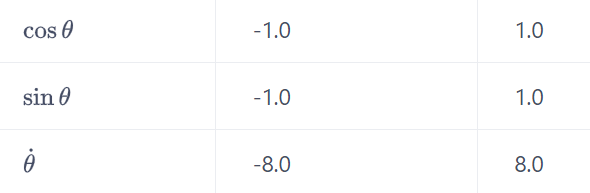

### Action space

* Continuous action space
* Torque in the range between -2 and 2.
* In order to use it in DQN, we will discretize the continuous action space into 11 actions, to better demonstrate the overestimated Q-value

In [7]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

In [8]:
env.action_space.sample()

array([0.13062288], dtype=float32)

In [9]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # discretize continuous action into 11 discrete actions


# discrete_action is integer from [0, 1, 2, 3, ... 10], representing torque [-2, -1.6, -1.2, ... 1.2, 1.6, 2]
def dis_to_con(discrete_action, env, action_dim):  # discrete to continuous
    action_lowbound = env.action_space.low[0]  # min of continuous action space
    action_upbound = env.action_space.high[0]  # max of continuous action space
    return action_lowbound + (discrete_action /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

### Create a simple network

In [10]:
class Qnet(torch.nn.Module):
    ''' with single hidden layer '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### Modify the existing DQN code from last class

In [11]:
class DQN:
    ''' DQN and Double DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'): # specify which DQN to use. VanillaDQN by default.
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # predict Q-values
        # Max Q-value of the next state
        if self.dqn_type == 'DoubleDQN': 
            ########################################################################
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
            ########################################################################
        else: # Vanilla DQN
            ########################################################################
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
            ########################################################################
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD error targets
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # MSE loss
        self.optimizer.zero_grad()  # Since PyTorch accumulate gradients by default. Need to cleans the gradients
        dqn_loss.backward()  # backpropogation to compute parameters
        self.optimizer.step() # update the parameters

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # Update target network by copying weights from qnet to target_qnet
        self.count += 1

In [12]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state, _ = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # smooth the value
                    max_q_value_list.append(max_q_value)  # store the max Q-value of every state
                    action_continuous = dis_to_con(action, env,
                                                   agent.action_dim)
                    next_state, reward, terminated, truncated, info = env.step([action_continuous]); done = truncated or terminated
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

### Experience replay buffer from last class

In [13]:
from tqdm import tqdm
import numpy as np
import torch
import collections
import random
    
class ReplayBuffer:
    ''' Experience replay buffer '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # allocate the memory

    def add(self, state, action, reward, next_state, done):  # add an observation {𝑠𝑖,𝑎𝑖,𝑟𝑖,𝑠′𝑖, done} into buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  
        # randomly pick samples from buffer with batch_size to break
        # the correlational structure in the training data.
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # the current observation size in buffer
        return len(self.buffer)
    
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

### Now let's train vanilla DQN and check the max Q-values

**Overestimated Q-values are above orange line**

Iteration 0:   0%|                                                                              | 0/20 [00:00<?, ?it/s]C:\Users\damin\AppData\Local\Temp\ipykernel_18124\476407828.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
C:\Users\damin\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|███████████████████████████████████████| 20/20 [00:15<00:00,  1.28it/s, episode=200, return=-207.577]


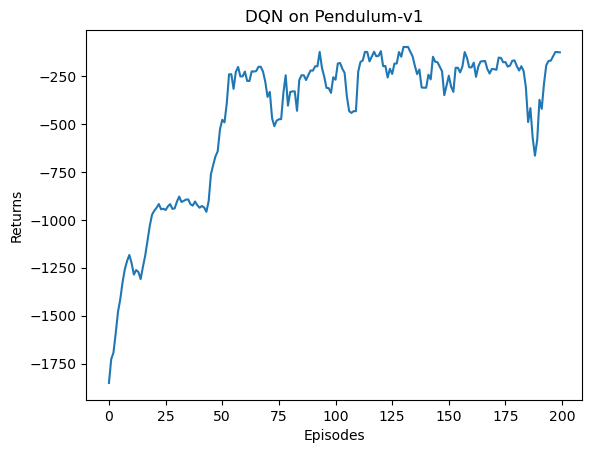

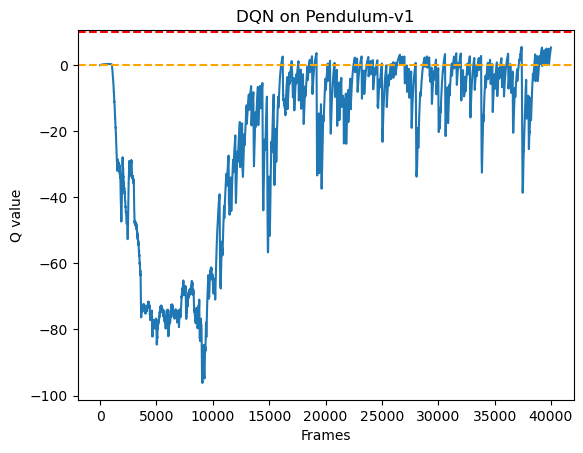

In [14]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

### Let's train the double DQN and check the max Q-values

* It still has some overestimations but seems much better.

Iteration 9: 100%|███████████████████████████████████████| 20/20 [00:09<00:00,  2.10it/s, episode=200, return=-170.399]


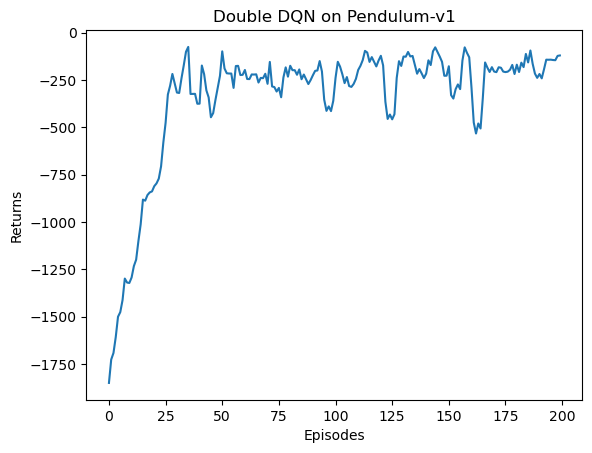

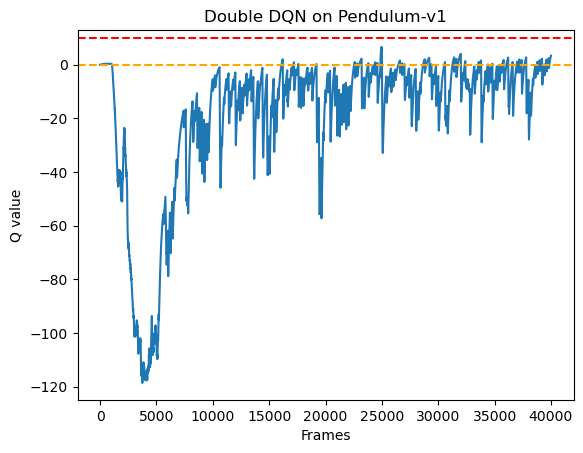

In [15]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

## Dueling DQN

* Instead of directly predicting a single $Q$-value for each action, the dueling architecture splits the final convolutional layer into two streams
    - the value function that predict a *state value* $V(s)$ that depends only on the state, 
    - and *action advantages* $A(s,a)$ that depend on the state and the respective action. 
    - i.e., the *state value* $V(s)$ predicts *how good it is to be in a certain state* $s$ and the *action advantage* $A(s,a)$ predicts *how good it is to perform action $a$ in state $s$*.

* Intuition for dueling DQN
    - the dueling architecture can learn which states are (or are not) valuable, without having to learn the effect of each action for each state. 
    - This is particularly useful in states where its actions do not affect the environment in any relevant way. 
    - the dueling architecture can more quickly identify the correct action during policy evaluation as redundant or similar actions are added to the learning problem. 



Next, we have to combine the value and advantage stream into $Q$-values $Q(s,a)$:
$$\large
\begin{equation}
Q(s,a) = V(s) + \left(A(s,a) - \frac 1{| \mathcal A |}\sum_{a'}A(s, a')\right)
\end{equation}
$$
Why so complicated instead of just adding $V(s)$ and $A(s,a)$? Let's assume $Q(s,a) = V(s) + A(s,a)$:

 The Q function measures the value of choosing a particular action when in a particular state. The value function $V$, which is the expected value of $Q$ over all possible actions, $V = E(Q)$, measures how good it is to be in this particular state. 

If you combine $E(Q) = V$ and $Q = V + A$, you find $E(Q) = E(V) + E(A)$. But $V$ does not depend on any action, which means $E(V)=V$, $E(Q) = V + E(A) = V$ and thus $E(A)=0$. The expected value of the advantage $A(s,a')$ over all possible actions $a'$ has to be zero. The expected value of the expression in parentheses is zero because we subtract the mean of the advantages from every advantage:
$$\large
\begin{equation}
E\left(A(s,a) - \frac 1{| \mathcal A |}\sum_{a'}A(s, a')\right) = E\Bigl(A - E(A)\Bigr) = E(A)- E(E(A)) = E(A) - E(A) = 0
\end{equation}$$

For example, 

* the school (the state) value is average salary $V(s)=\$150k$ after graduation over all possible students and situations.
* Your actions in the school will impact your actual salary up or down but on average the impact is zero.
* So, your actual salary is the school value + your action advantage over average
* Mean reversion

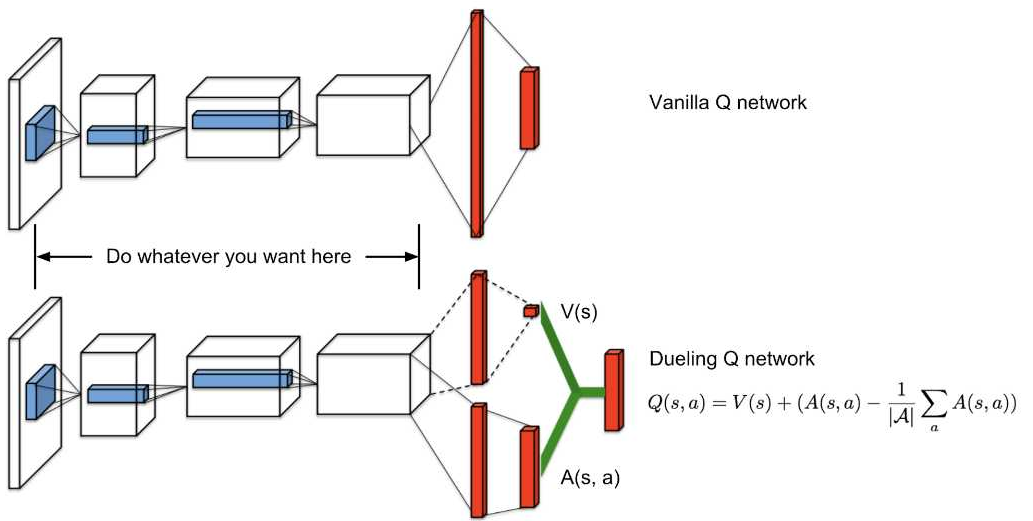

### Build the dueling network

In [16]:
class VAnet(torch.nn.Module):
    ''' V(s) and A(s, a) '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # V and A share the first part of the network       
        self.fc_V = torch.nn.Linear(hidden_dim, 1)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):        
        V = self.fc_V(F.relu(self.fc1(x)))
        A = self.fc_A(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # combine V and A to get final Q
        return Q

### Modify the above code to add Dueling DQN

In [17]:
class DQN:
    ''' Vanilla DQN, Double DQN and Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN will use different network
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else: # vanilla DQN and dueling DQN are same here
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

Iteration 9: 100%|███████████████████████████████████████| 20/20 [00:21<00:00,  1.10s/it, episode=200, return=-199.593]


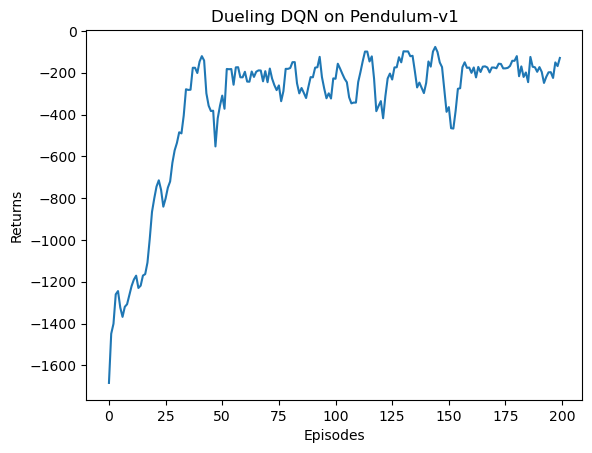

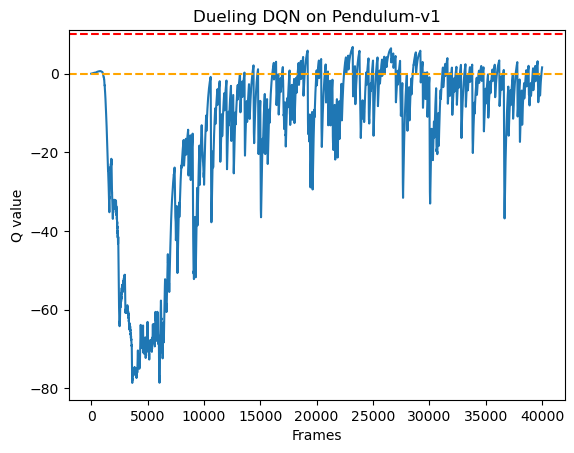

In [18]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

## Let's see how the trained agent performs

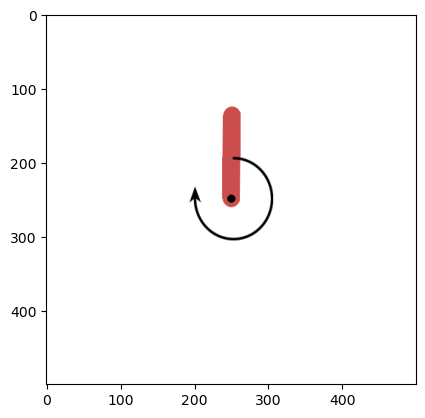

In [39]:
from IPython.display import clear_output
from IPython import display

# Render after training
env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode='rgb_array')
state, _ = env.reset()

for i in range(50):
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action = agent.take_action(state)
    action_continuous = dis_to_con(action, env, agent.action_dim)
    state, reward, terminated, truncated, info = env.step([action_continuous]); done = truncated or terminated

    if done:
        state, _ = env.reset()
env.close()

# Homework

* We split the continuous action space into 11 discrete actions. Increase the number (to 15, 25, 35 etc) to test the three DQN versions and compare the results. 